# 1. Attention의 구조

In [1]:
## 이번 장에서는 지금까지 배운 seq2seq를 한 층 더 강력하게 하는 어텐션 메커니즘이라는 아이디어를 소개한다.
## 이 메커니즘 덕에 seq2seq는 필요한 정보에만 '주목'할 수 있게 된다.
## 또 seq2seq의 근본적인 문제를 해결할 수도 있다.

### seq2seq의 문제점

In [2]:
## seq2seq에서는 Encoder가 시계열 데이터를 인코딩한다. 이때 출력은 '고정 길이 벡터'였다.
## 그런데 이 '고정 길이'라는 데에 큰 문제가 잠재해 있다.
## 고정 길이 벡터는 입력 문장의 길이에 관계없이 항상 같은 길이의 벡터로 변환한다.
## 이는 입력 문장이 길어질수록 필요한 정보가 벡터에 다 담기지 못하게 되는 현상이 발생한다.

### Encoder의 개선

In [3]:
## Encoder 출력의 길이는 입력 문장의 길이에 따라 바꿔주는 게 좋다. 이 점이 개선 포인트다.
## 구체적으로 시각별 LSTM 계층의 은닉 상태 벡터 모두 이용하는 것이다.

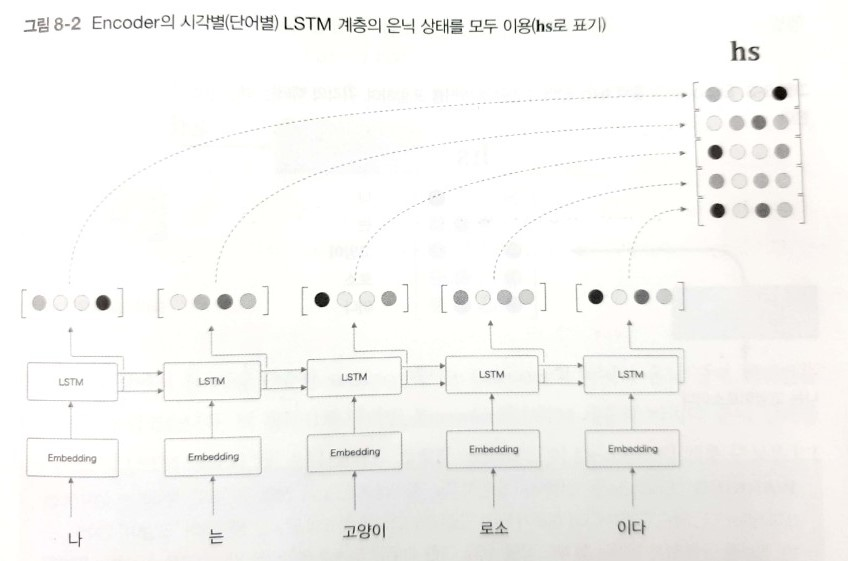

In [6]:
from IPython.display import Image

Image('Encoder Improve.jpg', width = 500, height = 400)

In [7]:
## 각 시각의 은닉 상태 벡터를 모두 이용하면 입력된 문장의 단어 수와 같은 수의 벡터를 얻을 수 있다. 
## 그림에서 5개의 단어가 입력되었고, Encoder는 5개의 벡터를 출력한다.
## 이것으로 Encoder는 고정 길이 벡터라는 제약에서 해방된다.
## Encoder가 출력하는 hs 행렬은 각 단어에 해당하는 벡터들의 집합이라고 볼 수 있다.
## 단지 Encoder의 은닉 상태를 모든 시각만큼 꺼냈을 뿐이지만, 이 작은 개선 덕분에 문장 길이에 비례한 정보를
## 인코딩할 수 있게 되었다.

### Decoder의 개선 - (1)

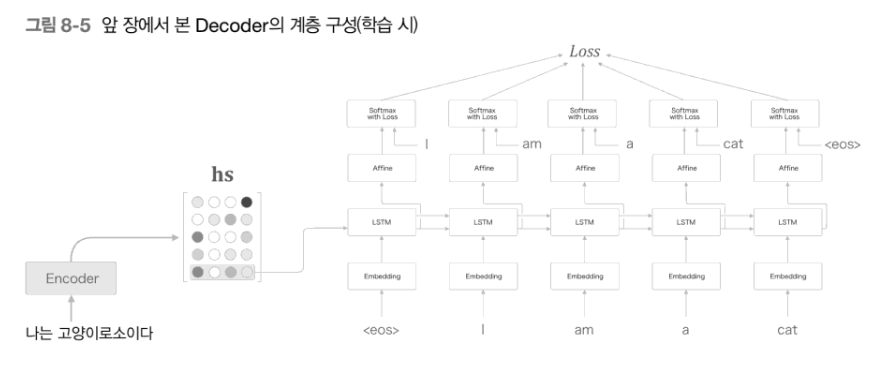

In [13]:
Image('Prev Decoder.jpg', width = 500, height = 500)

In [14]:
## 앞 장의 Decoder는 hs에서 마지막 줄만 빼내어 Decoder에 전달한 것과 같았다.
## 그래서 hs 전부를 활용할 수 있도록 개선해볼 것이다.

In [15]:
## 사람이 문장을 번역할 때 보통 어떤 단어에 주목하여 그 단어의 변환을 수시로 하게 된다.
## 나 = I, 고양이 = cat과 같이 입력과 출력의 여러 단어 중 어떤 단어끼리 서로 관련되어 있는지 대응관계를
## seq2seq에 학습시킬 수 없을까?

In [18]:
''' 기계번역의 역사를 보면 단어의 대응 관계 지식을 이용하는 연구는 많이 이뤄져 왔다.
    단어의 대응관계를 나타내는 정보를 얼라인먼트(alignment)라 하는데, 지금까지는 주로 사람이 수작업으로 만들었다.
    그러나 어텐션 기술은 얼라인먼트라는 아이디어를 자동으로 seq2seq에 도입하는 데 성공했다.'''

' 기계번역의 역사를 보면 단어의 대응 관계 지식을 이용하는 연구는 많이 이뤄져 왔다.\n    단어의 대응관계를 나타내는 정보를 얼라인먼트(alignment)라 하는데, 지금까지는 주로 사람이 수작업으로 만들었다.\n    그러나 어텐션 기술은 얼라인먼트라는 아이디어를 자동으로 seq2seq에 도입하는 데 성공했다.'

In [19]:
## 앞으로 우리 목표는 도착어와 대응 관계에 있는 출발어의 정보를 골라내는 것이다.
## 그리고 그 정보로 번역을 수행한다.

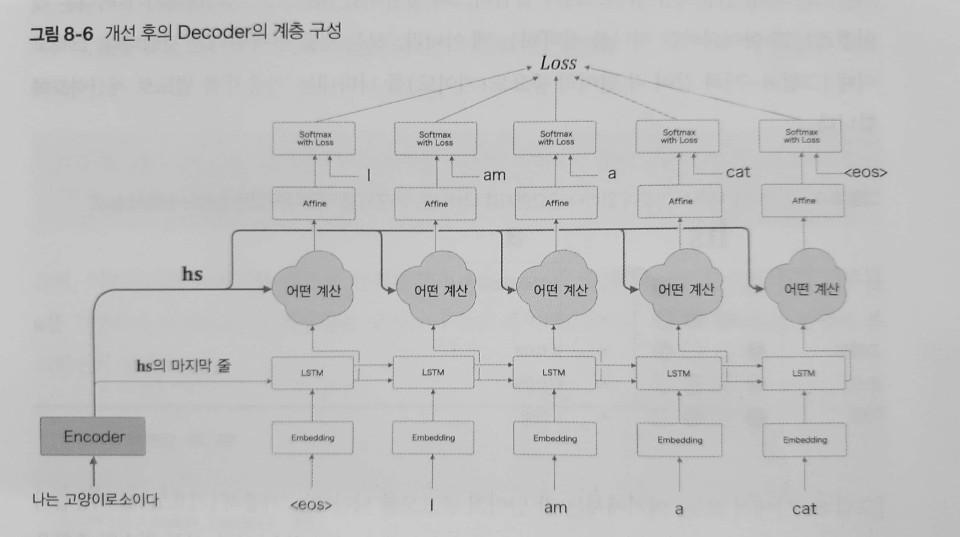

In [21]:
Image('Decoder Improve1.jpg', width = 500, height = 500)

In [22]:
## 그림에서처럼 '어떤 계산'을 수행하는 계층을 추가할 것이다.
## 이 계층이 받는 입력은 두 가지로, 하나는 Encoder로부터 받는 hs이고, 다른 하나는 시각별 LSTM 계층의 은닉 상태이다.
## 그리고 여기서 필요한 정보만 골라 위쪽의 Affine 계층으로 출력한다.
## 참고로, 지금까지와 똑같이 Encoder의 마지막 은닉 상태 벡터는 Decoder의 첫 번째 LSTM 계층에 전달한다.

In [23]:
## 위 그림의 신경망으로 하고 싶은 일은 단어들의 얼라인먼트를 추출하는 것이다.
## 각 시각에서 Decoder에 입력된 단어와 대응 관계인 단어의 벡터를 hs에서 골라내겠다는 뜻이다.
## 하지만 여기서 선택하는 작업은 미분할 수 없다는 문제가 발생한다.
## 미분 가능한 연산을 이용하지 않으면 오차역전파법을 사용할 수 없다.

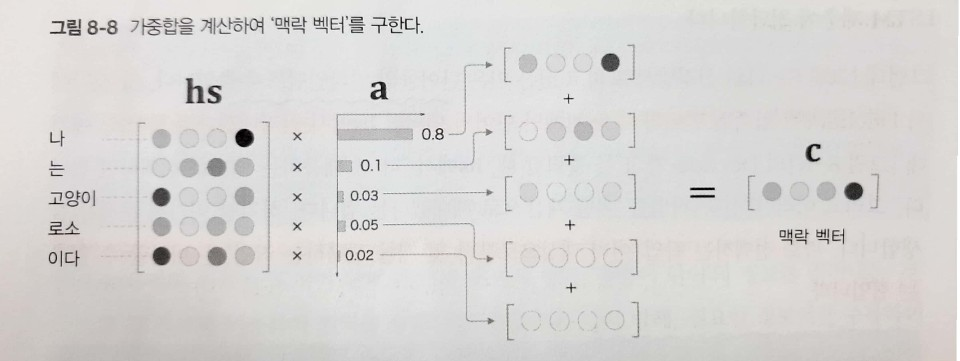

In [25]:
## 이 문제를 해결하는 아이디어는 '하나를 선택'하는 게 아니라, '모든 것을 선택'하는 것이다.
## 이때 각 단어의 중요도를 나타내는 '가중치'를 별도로 계산하도록 한다.
Image('context vector.jpg', width = 500, height = 500)

In [27]:
## 각 단어의 중요도를 나타내는 가중치(a)와 각 단어의 벡터 hs로부터 가중합을 구하여 맥락벡터(c)를 구한다.
## 맥락 벡터에는 "나" 벡터의 성분이 많이 포함되어 있다
## 만약 "나"에 대응하는 가중치가 1이라면 "나" 벡터를 선택한다고 해석할 수 있다.

In [28]:
## Encoder가 출력하는 hs와 각 단어의 가중치 a를 적당하게 작성하고, 그 가중합을 구하는 구현을 해보자

In [29]:
import numpy as np

T, H = 5, 4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

ar = a.reshape(5, 1).repeat(4, axis = 1)
print(ar.shape)

(5, 4)


In [30]:
t = hs * ar
print(t.shape)

(5, 4)


In [31]:
c = np.sum(t, axis = 0)
print(c.shape)

(4,)


In [37]:
## 계속해서 미니배치 처리용 가중합을 구현한다.

In [38]:
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis = 2)
# ar = a.reshape(N, T, 1) # 브로드캐스트를 사용하는 경우

t = hs * ar
print(t.shape)

(10, 5, 4)


In [39]:
c = np.sum(t, axis = 1)
print(c.shape)

(10, 4)


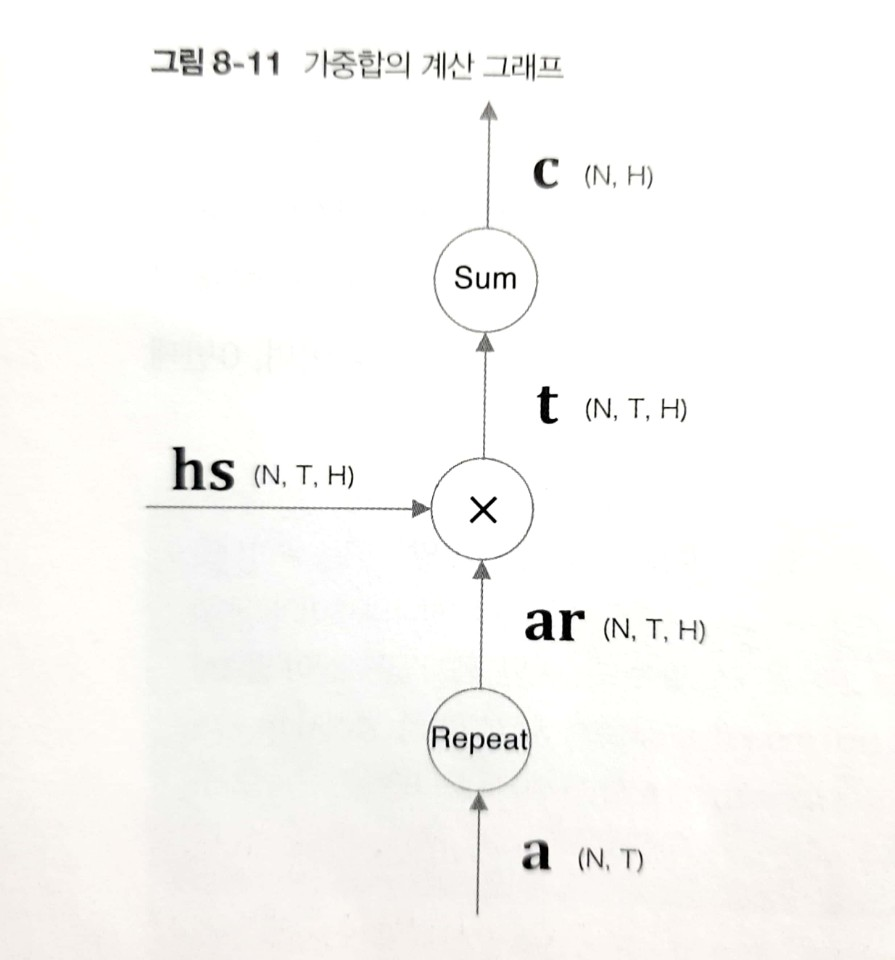

In [40]:
Image('가중합계산그래프.jpg', width = 320, height = 230)

In [41]:
## repeat노드를 사용해 a를 복제하고, x 노드로 원소별 곱을 계산한 뒤 sum 노드로 합을 구한다.

In [42]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar = a.reshape(N, T, 1).repeat(H, axis = 2)
        t = hs * ar
        c = np.sum(t, axis = 1)
        
        self.cache = (hs, ar)
        return c
    
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N, 1, H).repeat(T, axis = 1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis = 2)
        
        return dhs, da

### Decoder 개선 - (2)

In [43]:
## 각 단어의 중요도를 나타내는 가중치 a는 어떻게 구할까?

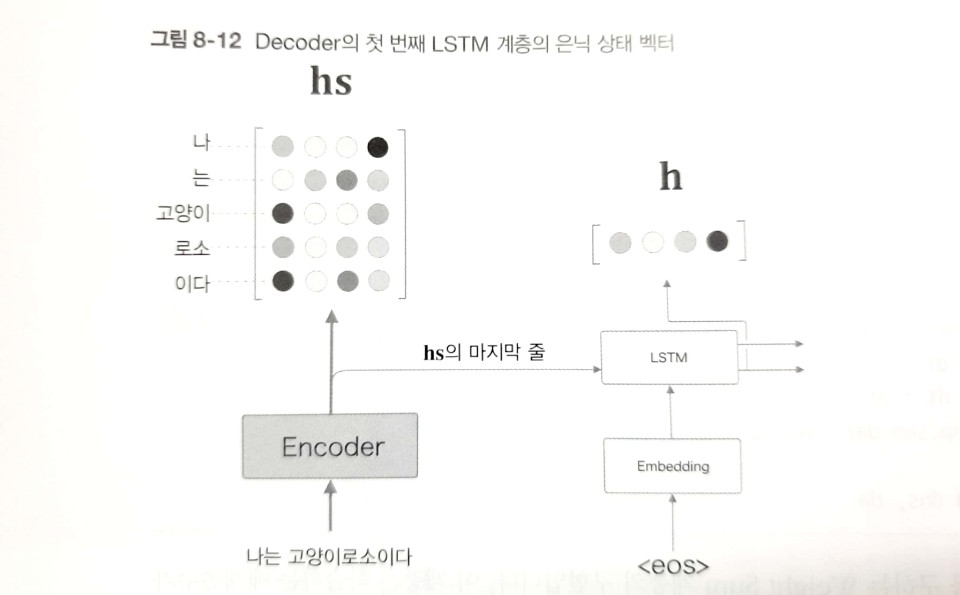

In [44]:
Image('Decoder first hidden state vector.jpg', width = 500, height = 400)

In [45]:
## 목표는 h가 hs의 각 단어 벡터와 얼마나 '비슷한가'를 수치로 나타내는 것이다.
## 여기서는 가장 단순한 방법인 벡터의 내적을 이용해 유사함을 계산할 것이다.

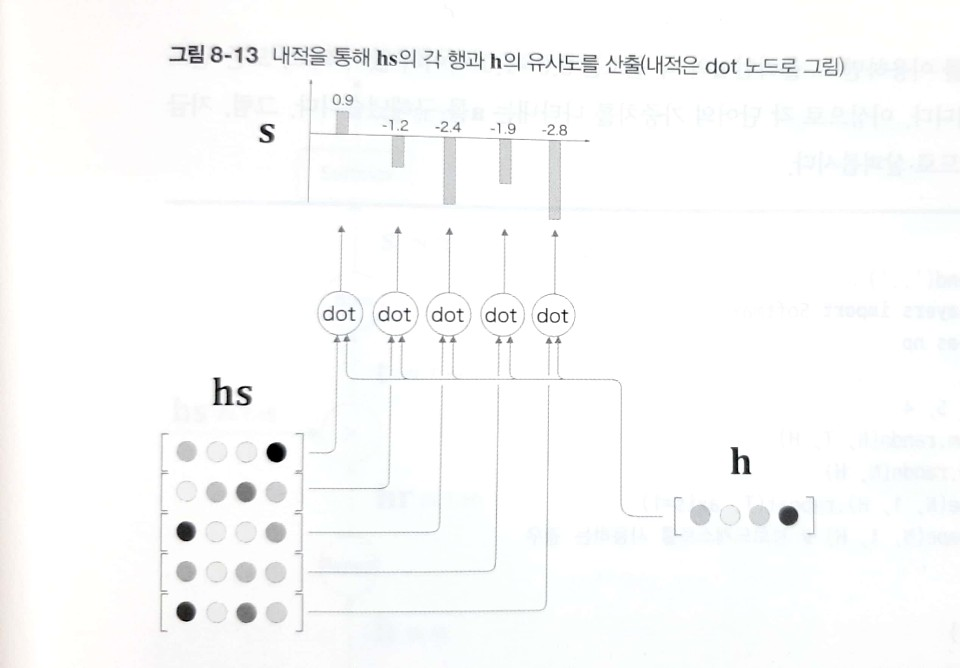

In [49]:
Image('유사도 산출.jpg', width = 500, height = 400)

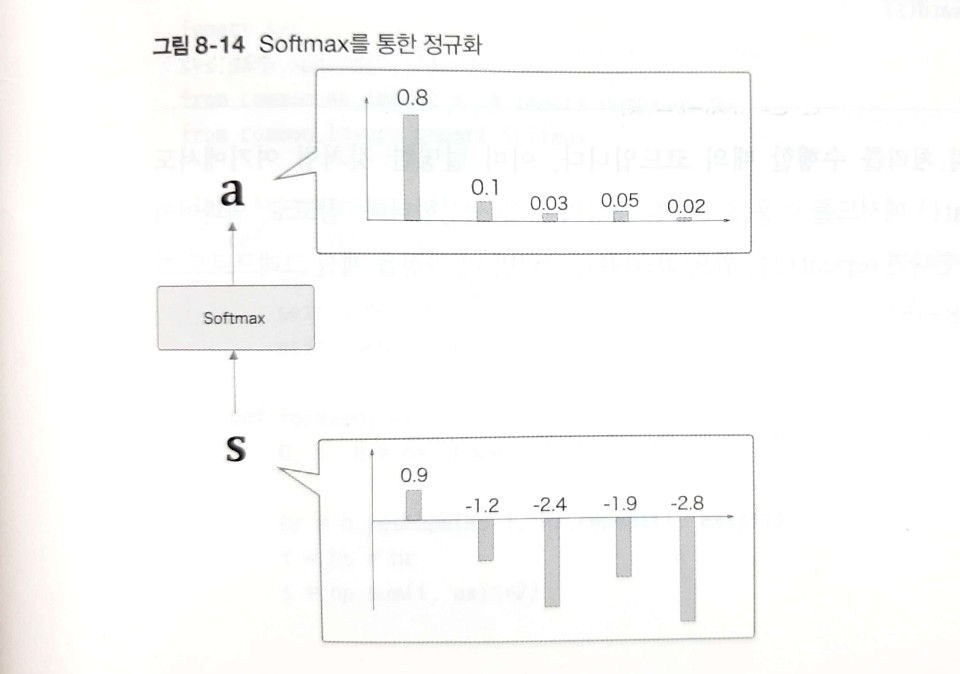

In [50]:
Image('소프트맥스 정규화.jpg', width = 500, height = 400)

In [51]:
## 벡터의 내적을 이용해 h와 hs의 각 단어 벡터 유사도를 구한다.
## 계속해서 소프트맥스 함수를 적용해 0과 1 사이 값으로 정규화 한다.

In [53]:
import sys
sys.path.append('..')
from common.layers import Softmax
import numpy as np

N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
h = np.random.randn(N, H)
hr = h.reshape(N, 1, H).repeat(T, axis = 1)
# hr = h.reshape(N, 1, H) # 브로드캐스트 사용

t = hs * hr
print(t.shape)

s = np.sum(t, axis = 2)
print(s.shape)

softmax = Softmax()
a = softmax.forward(s)
print(a.shape)

(10, 5, 4)
(10, 5)
(10, 5)


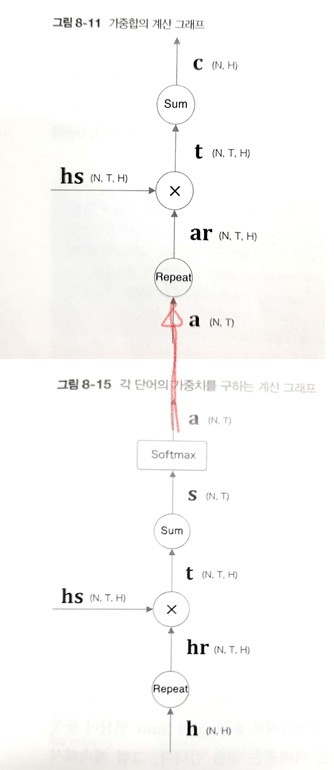

In [62]:
Image('맥락벡터 구하기.jpg', width = 400, height = 800)

In [63]:
## 맥락벡터 c를 구하는 클래스는 앞에서 구현한 WeightSum 클래스이고,
## 가중치 a를 구하는 클래스는 여기서 구현할 AttentionWeight 클래스이다.

In [64]:
class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh

### Decoder 개선 - (3)

In [65]:
## 지금까지 구현한 AttentionWeight과 WeightSum을 하나로 결합해보자

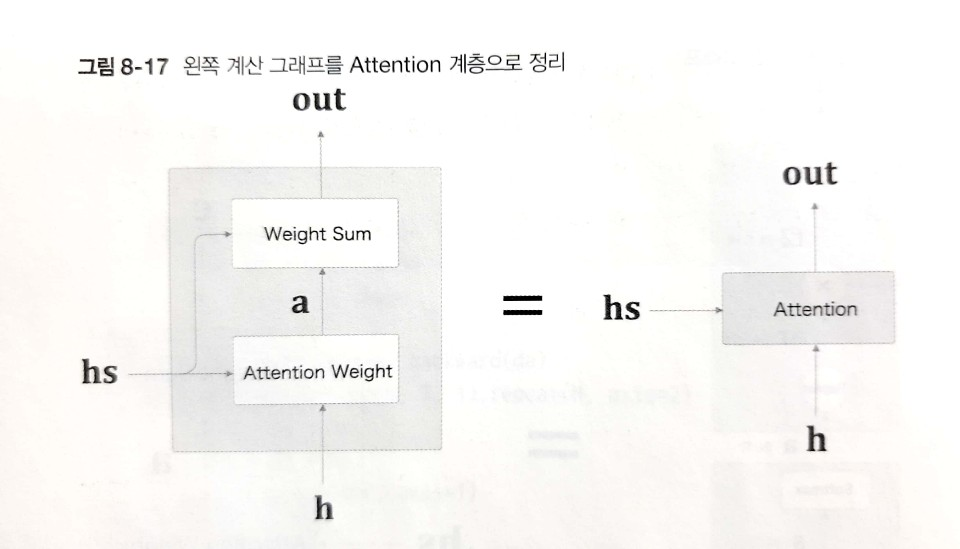

In [66]:
Image('어텐션 계층.jpg', width = 500, height = 500)

In [67]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None
        
    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out
    
    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh    

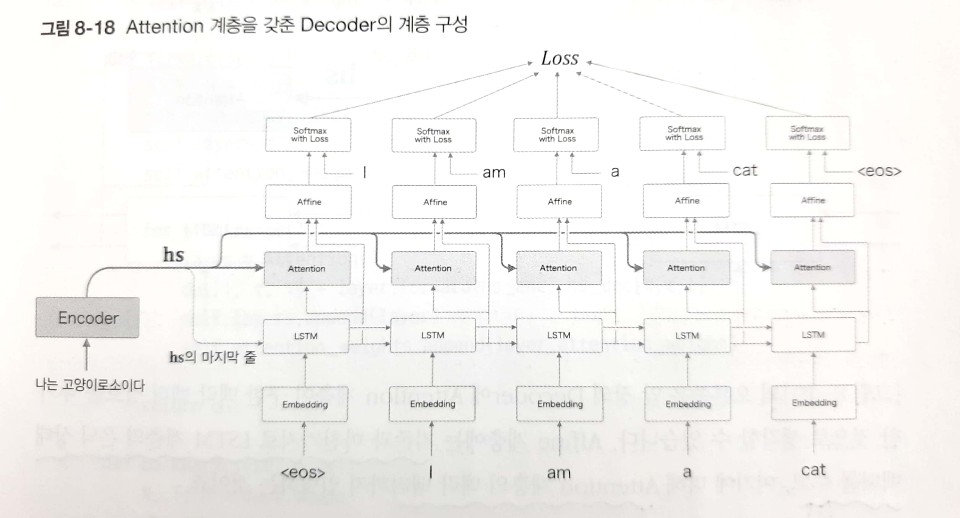

In [69]:
Image('어텐션을 추가한 Decoder.jpg', width = 600, height = 600)

In [70]:
## Attention 계층은 LSTM과 Affine 계층 사이에 삽입하면 된다.
## Attention 계층의 삽입으로 인해 Decoder에 어텐션 정보(유사도, 중요도)를 추가할 수 있게 되었다.

In [71]:
## Affine 계층에는 '맥락 벡터'와 '은닉 상태 벡터'라는 2개의 벡터가 입력된다.

In [72]:
## 이제 시계열 방향으로 펼쳐진 다수의 Attention 계층을 Time Attention 계층으로 모아 구현해보자

In [73]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec

In [74]:
## Attention 계층을 필요한 수만큼 만들고(T개), 순전파와 역전파를 수행한다.
## 또한 각 Attention 계층의 각 단어의 가중치(a)를 attention_weights 리스트에 보관한다.

# 2. 어텐션을 갖춘 seq2seq 구현

In [75]:
## 앞장의 seq2seq와 마찬가지로 어텐션을 갖춘 seq2seq는 
## 3개의 클래스(AttentionEncoder, AttentionDecoder, Attentionseq2seq)로 구현한다.

In [76]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from ch07.seq2seq import Encoder, Seq2seq
from ch08.attention_layer import TimeAttention


class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled


class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads


# 3. 어텐션 평가

In [77]:
## 이제 AttentionSeq2seq 클래스를 사용해 현실적인 문제에 도전해보자
## 여기서는 '날짜 형식'을 변경하는 문제를 풀어보자

In [78]:
## 날짜 변환용 데이터 셋으로 AttentionSeq2seq 학습하는 코드

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 13[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 25[s] | 손실 1.90
| 에폭 1 |  반복 61 / 351 | 시간 38[s] | 손실 1.72
| 에폭 1 |  반복 81 / 351 | 시간 51[s] | 손실 1.46
| 에폭 1 |  반복 101 / 351 | 시간 64[s] | 손실 1.19
| 에폭 1 |  반복 121 / 351 | 시간 76[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 89[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 101[s] | 손실 1.06
| 에폭 1 |  반복 181 / 351 | 시간 114[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 127[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 139[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 152[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 165[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 178[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 191[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 203[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 216[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
X 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
X 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
X 1978-08-11
---
Q Tuesday, November

Q 10/28/13                     
T 2013-10-28
O 2013-10-28
---
Q sunday, november 6, 2016     
T 2016-11-06
O 2016-11-06
---
정확도 99.920%
| 에폭 7 |  반복 1 / 351 | 시간 0[s] | 손실 0.00
| 에폭 7 |  반복 21 / 351 | 시간 12[s] | 손실 0.00
| 에폭 7 |  반복 41 / 351 | 시간 25[s] | 손실 0.00
| 에폭 7 |  반복 61 / 351 | 시간 37[s] | 손실 0.00
| 에폭 7 |  반복 81 / 351 | 시간 50[s] | 손실 0.00
| 에폭 7 |  반복 101 / 351 | 시간 62[s] | 손실 0.00
| 에폭 7 |  반복 121 / 351 | 시간 74[s] | 손실 0.00
| 에폭 7 |  반복 141 / 351 | 시간 87[s] | 손실 0.00
| 에폭 7 |  반복 161 / 351 | 시간 99[s] | 손실 0.00
| 에폭 7 |  반복 181 / 351 | 시간 111[s] | 손실 0.00
| 에폭 7 |  반복 201 / 351 | 시간 124[s] | 손실 0.00
| 에폭 7 |  반복 221 / 351 | 시간 136[s] | 손실 0.00
| 에폭 7 |  반복 241 / 351 | 시간 149[s] | 손실 0.00
| 에폭 7 |  반복 261 / 351 | 시간 161[s] | 손실 0.00
| 에폭 7 |  반복 281 / 351 | 시간 173[s] | 손실 0.00
| 에폭 7 |  반복 301 / 351 | 시간 186[s] | 손실 0.00
| 에폭 7 |  반복 321 / 351 | 시간 198[s] | 손실 0.00
| 에폭 7 |  반복 341 / 351 | 시간 210[s] | 손실 0.00
Q 10/15/94                     
T 1994-10-15
O 1994-10-15
---
Q thursd

C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 54253 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LoteeYoon\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 

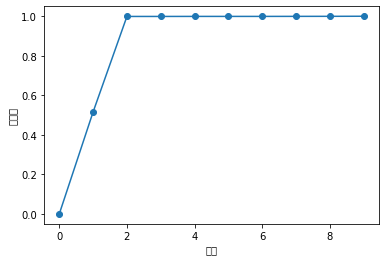

In [80]:
# coding: utf-8
import sys
sys.path.append('..')
sys.path.append('../ch07')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch08.attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq


# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('정확도 %.3f%%' % (acc * 100))


model.save_params()

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(-0.05, 1.05)
plt.show()


# 4. 어텐션에 관한 남은 이야기

### 양방향 RNN

In [ ]:
## 앞에서 Encoder를 보면 LSTM 계층의 모든 시각의 은닉 상태 벡터는 hs로 모아졌다.
## 여기서 주목할 점은 '나는 고양이로소이다.'를 입력했을 때, '고양이'에 대응하는 벡터에 '나', '는', '고양이'까지 총 세 단어의
## 정보가 인코딩되어 들어간다. 여기에서 '고양이' 단어의 주변 정보를 균형있게 담고 싶어진다.

## 그래서 LSTM을 양방향으로 처리하는 방법을 생각할 수 있다.
## 이것이 양방향 LSTM(BERT) 기술이다.

In [ ]:
## 양방향 LSTM에서는 지금까지의 LSTM 계층에 더해 역방향으로 처리하는 LSTM 계층도 추가한다.
## 그리고 각 시각에서는 이 두 LSTM 계층의 은닉 상태를 연결시킨 벡터를 최종 은닉 상태로 처리한다.
## (연결 외에도 합하거나 평균내는 방법 등도 있다.)

## 이렇게 해서 균형잡힌 정보가 인코딩된다.

In [ ]:
Image('BERT.jpg', width = 500, height = 500)

### Attention 계층 사용 방법

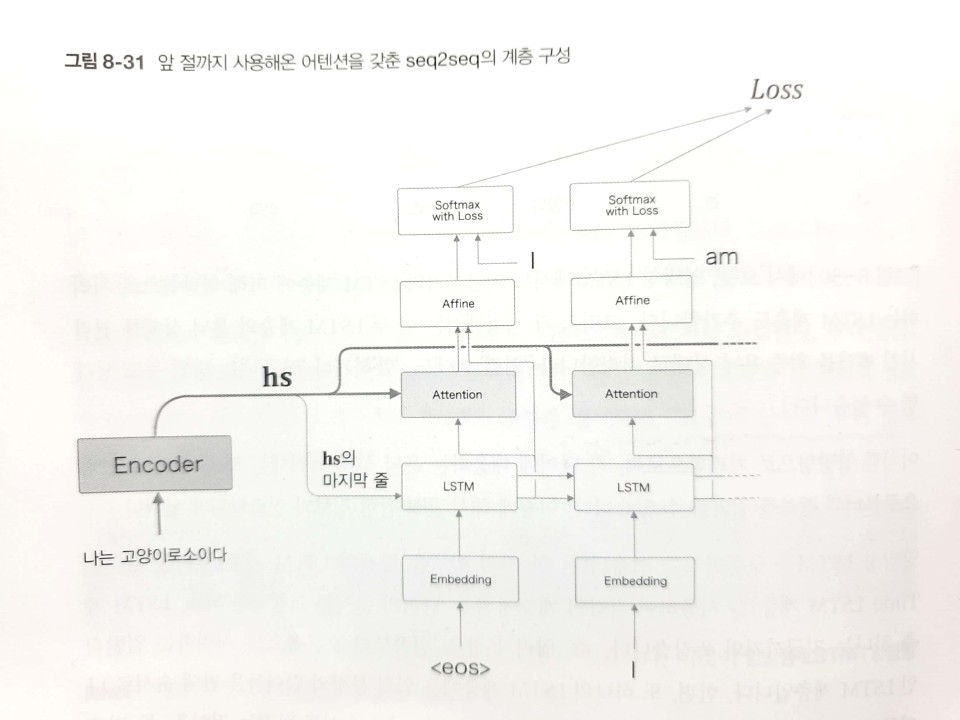

In [3]:
## 어텐션 계층을 반드시 Affine과 LSTM 계층 사이에 넣을 필요는 없다.
from IPython.display import Image
Image('기존어텐션.jpg', width = 500, height = 500)

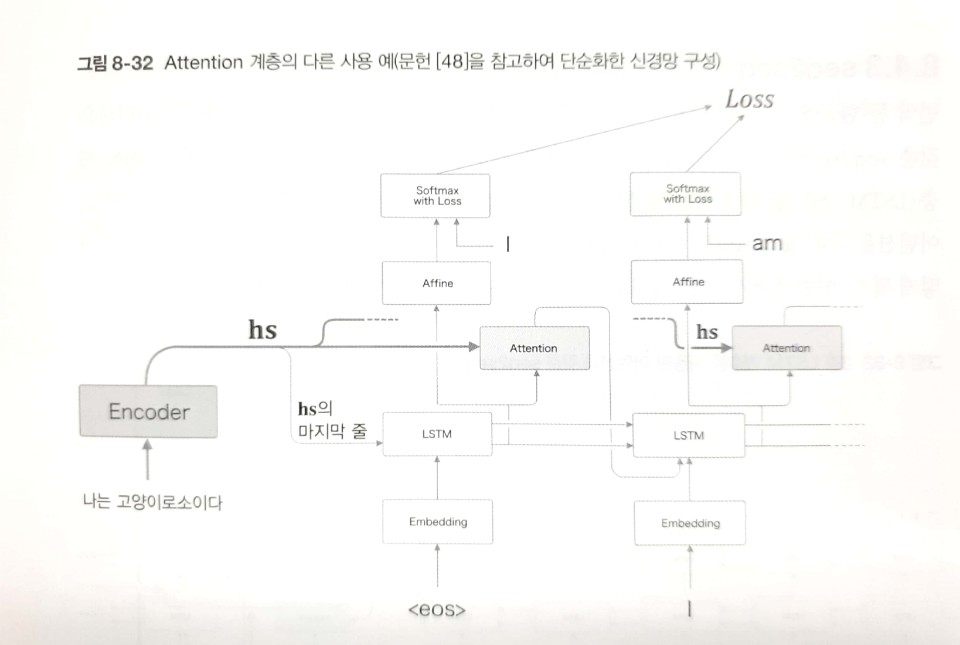

In [4]:
Image('어텐션 다른 사용.jpg', width = 500, height = 500)

In [5]:
## 어텐션 계층의 출력이 다음 시각의 LSTM 계층에 입력되도록 연결할 수도 있다.
## 이렇게 구성하면 LSTM 계층이 맥락 벡터의 정보를 이용할 수 있게된다.
## 한편 우리가 구현한 모델은 Affine 계층이 맥락 벡터를 이용했다.

## Attention 계층의 위치를 달리하는 게 최종 정확도에는 어떤 영향을 줄까?
## 그건 해보지 않으면 모른다. 현실은 실제 데이터를 사용해 검증할 수밖에 없다.

### seq2seq 심층화와 skip connection

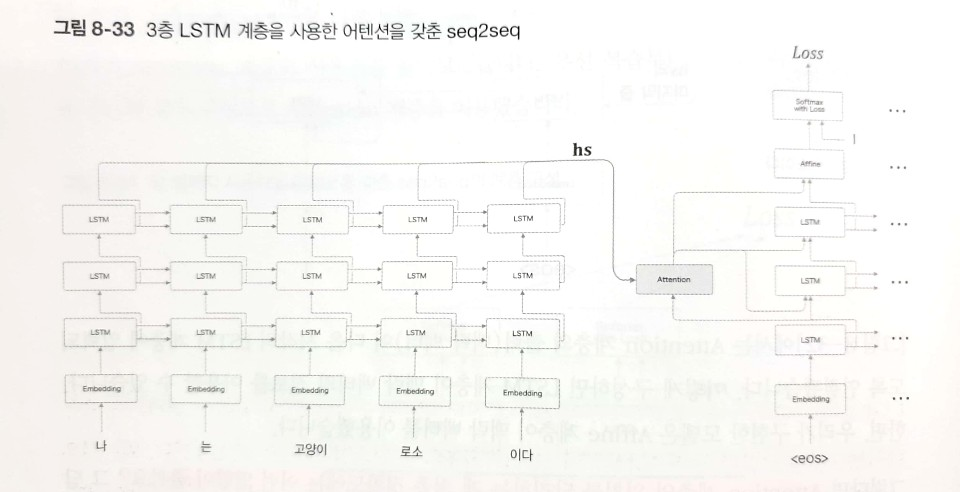

In [8]:
## 번역 등 현실에서의 애플리케이션들은 풀어야 할 문제가 훨씬 복잡하다. 
## 그렇다면 어텐션을 갖춘 seq2seq에도 더 높은 표현력이 요구될 것이다.
## 이때 우선 생각해야 할 것은 RNN 계층을 깊게 쌓는 방법이다.
## 층을 깊게 쌓으면 표현력 높은 모델을 만들 수 있고, 어텐션을 갖춘 seq2seq도 다르지 않다.

## 한 가지 예로 3층 LSTM 계층을 사용한 모델을 보자
Image('계층심층화.jpg', width = 600, height = 600)

In [9]:
## Encoder와 Decoder로 3층 LSTM을 사용하고 있다.
## 이처럼 Encoder와 Decoder에서는 같은 층수의 LSTM 계층을 이용하는 것이 일반적이다.

## 한편, 어텐션 계층의 사용법은 여러 변형이 있을 수 있다.
## 여기서는 Decoder의 LSTM 계층의 은닉상태를 어텐션 계층에 입력하고
## 어텐션 계층의 출력인 맥락 벡터를 Decoder의 여러 계층으로 전파한다.

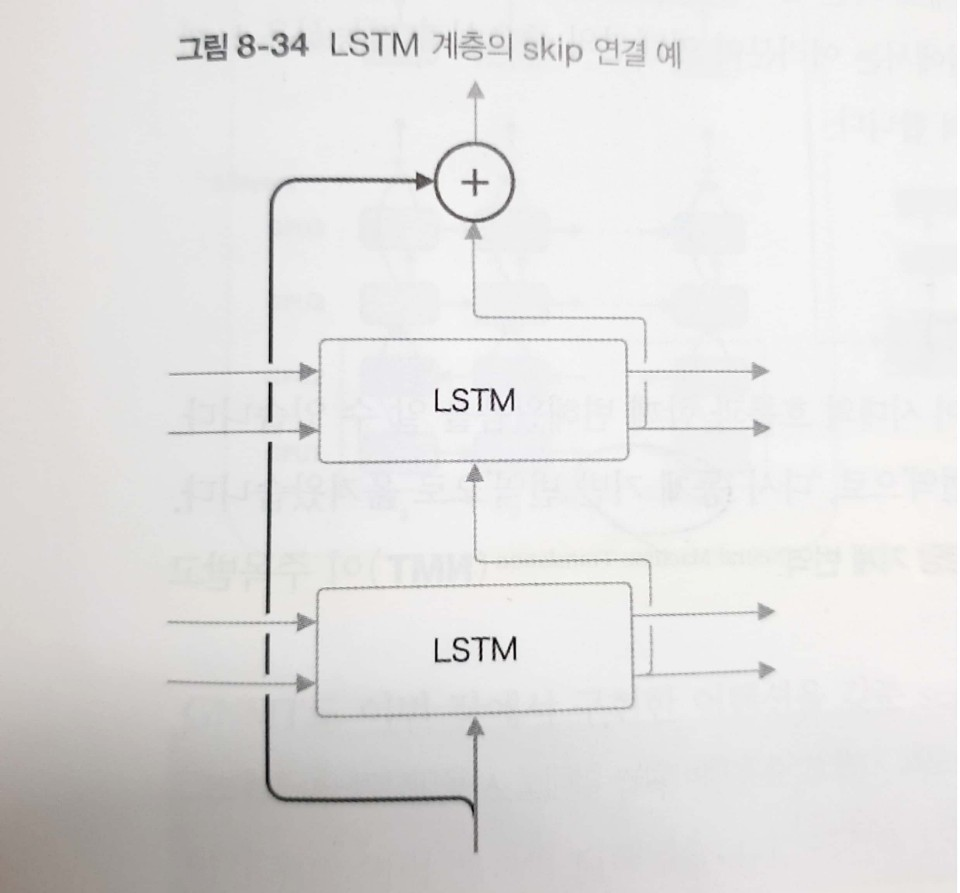

In [11]:
## 층을 깊게 할 때 사용되는 중요한 기법 중 skip 연결(skip connection)이라는 게 있다.
Image('skip 연결.jpg', width = 300, height = 300)

In [12]:
## skip 연결은 계층을 건너뛰는 연결이다.
## 이때 skip 연결의 접속부에서는 2개의 출력이 더해진다.
## 이 덧셈(원소별 덧셈)이 핵심이다.
## 덧셈은 역전파 시 기울기를 그대로 흘려보내므로, skip 연결의 기울기가 아무런 영향을 받지 않고 모든 계층으로 흐르기 때문이다.
## 따라서 층이 깊어져도 기울기가 소실(혹은 폭발)되지 않고 전파되어, 좋은 학습을 기대할 수 있다.

In [13]:
'''
    시간방향 기울기 소실 : LSTM, GRU
    시간방향 기울기 폭발 : gradient clipping
    
    깊이방향 기울기 소실, 폭발 : skip - connection
'''

'\n    시간방향 기울기 소실 : LSTM, GRU\n    시간방향 기울기 폭발 : gradient clipping\n    \n    깊이방향 기울기 소실, 폭발 : skip - connection\n'